## Ensemble & Analyze Climate Experiments

Notebook 3/X

In notebook 1/X we created configuration files for both NeuralHydrology's (NH) Long Short-Term Memory model and the SACSMA-SNOW17 (SAC-SMA) model. In notebook 2/X we created, and potentially ran, the SAC-SMA job scripts. In notebook 3/X we will manually ensemble and subsequently analyze one set of climate experiments, assuming they have been trained and tested.

The outputs of this notebook include 1) USGS observed streamflow data DataFrame (sourced from CAMELS), 2) dictionary of experiments and their simulated runoff data, 3) dictionary of ensembled mean hydrographs, 4) dictionary of basin metrics, and 5) a dictionary containing cdfs plotting data for ease in the next analysis notebook. 

### Import Libraries

In [1]:
#Automatically reload modules; ensures most recent versions
%load_ext autoreload
%autoreload 2

In [2]:
#Import Python libraries
import os
import sys
import copy
import glob
import xarray
import logging
import numpy as np
from os import path
import pandas as pd
import pickle as pkl
from functions import * #load the million neuralhydrology functions I use here
from pathlib import Path
from ruamel.yaml import YAML
from tqdm.notebook import tqdm
from scipy import stats, signal
import matplotlib.pyplot as plt
from pathlib import Path, PosixPath
from typing import Dict, List, Tuple, Union
from xarray.core.dataarray import DataArray

### Define Parameters

This is the only section you will need to edit code in.

##### Most Important Experiment Parameters

As in the two previous notebooks, we need to first define which experiment set we want to ensemble and analyze. If the experiment set has been ensembled and analyzed before, the existing product files can be loaded in without having to go through the process all over again. Alternatively, the 'overwrite' variable allows the notebook to overwrite those existing files and create new ones. The 'lulc' variable defines the source of the Land Use Land Cover (LULC) dataset. The options include 'landsat' and 'modis'. CAMELS LULC data was derived from MODIS data.

In [3]:
#########################################################################################

#Specify which model we are ensembling and analyzing; 'nh' or 'sacsma'
model = 'nh'

#Specify climate index input type; 'static' or 'dynamic'
inputs = 'dynamic'

#Specify experiment type; 'extreme' or 'random'
exp_type = 'extreme'

#Specify forcing source
forcing = 'nldas_extended'

#Specify if all years or only years also avaliable for the National Water Model (NWM) are used
years = 'nwm'

#########################################################################################

##### Notebook Configuration

The overwrite variable allows this notebook to overwrite pre-existing files created by this notebook.

The 'plot_all_metrics' variable allows you to plot _all_ the avaliable metrics (listed below) or ONLY the Nash-Sutcliffe Efficiency Coefficient (NSE). All metrics are calculated regardless.

In [4]:
#########################################################################################

#If files already exist, should they be overwritten by this notebook?
overwrite = False

#Do we want to plot all metrics or just the NSE?
plot_all_metrics = False

#########################################################################################

##### Paths

Here we define our paths. New path variables include nh_dir (path to neuralhydrology directory), nh_runs_dir (path to the NH runs folder), sacsma_run_dir (path to SAC-SMA results directory), camels_forcing_dir (path to the CAMELS directory), env_saves_dir (path to notebook_env_saves directory). I have specified what the general path end should look like above each line to help with this.

Notably, the lulc dir refers to the directory containing LULC datasets concerning all USGS basins, including most of the CAMELS basins.Our LULC data was sourced from Mike Johnson (https://github.com/mikejohnson51/usgs-gage-landcover), a NOAA affiliate.

Additionally, the NWM run (nwm_streamflow) and CAMELS identification scheme (nwm_camels_ids) is sourced from Jonathan Frame's work (https://github.com/jmframe/nwm-post-processing-with-lstm) with the National Water Center in Tuscaloosa, Alabama. 

In [5]:
#########################################################################################

# Path to working directory (current directory)
working_dir = Path(os.getcwd())

#Path to main CAMELS directory (../camels)
camels_dir = working_dir / 'camels'

#Path to NH codebase (../neuralhydrology/neuralhydrology)
nh_dir = working_dir / 'neuralhydrology' / 'neuralhydrology'

#Path to CAMELS forcing directory (../basin_dataset_public_v1p2)
camels_forcing_dir = camels_dir / 'basin_dataset_public_v1p2'

#########################################################################################

#If you use this repository's directory structure, you not need to edit the paths below, but just in case...

#Path to sacsma results(../sacsma/results)
sacsma_runs_dir = working_dir / 'sacsma' / 'results'

# Path to notebook_env_saves
env_saves_dir = working_dir / 'notebook_env_saves'

#Path to NH runs (../runs/nh)
nh_runs_dir = working_dir / 'nh_lstm' / 'runs' / 'nh'

#Path to extreme dates directory (../extreme_year_dates)
dates_dir = working_dir / 'train_test_splits'

#Path to NWM run (../nwm_daily.pkl)
nwm_streamflow = working_dir / 'nwm_daily.pkl'

#Path to NWM CAMELS identification file
nwm_camels_ids = working_dir / 'camels_id.npy'

#Path to CAMELS attributes, version 2 file
camels_attributes_dir  = camels_dir / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

#Path to model's original experiment config files
configs_path = working_dir / f'nh_lstm/configs/run_configs/{model}/{inputs}/{exp_type}/{forcing}/{years}'

#########################################################################################

**You should not have to edit anything below this cell.**

The cell below orients the notebook based on the parameters specifed above.

In [6]:
#########################################################################################

#Point to NeuralHydrology codebase
sys.path.append(str(nh_dir))

#Import NeuralHydrology functions
from utils import config
from datautils.utils import load_basin_file

#########################################################################################

#Navigate to run directory based on model
if model == 'nh':
    
    exp_runs_dir = nh_runs_dir / inputs / exp_type / forcing / years 
    
if model == 'sacsma':
    
    exp_runs_dir = sacsma_runs_dir
    
    #Automatically set inputs to dynamic for SAC-SMA
    inputs = 'dynamic'
    
#########################################################################################

#Define index according to years used ('all' or 'nwm')
if years == 'nwm':
    
    #Index limited to years also avaliable for NWM
    index = pd.date_range('1995-10-01','2014-12-30')
    
if years == 'all':
    
    #All avaliable forcing years
    index = pd.date_range('1980-10-01','2014-12-30')

#########################################################################################

#Define avaliable metric functions and extract the names of those functions
metrics = [alpha_nse,beta_kge,beta_nse,kge,mse,nse,rmse,pearsonr] #fdc_fhv,fdc_flv,fdc_fms also avaliable

#Get names of avaliable metric functions
metrics_names = [x.__name__ for x in metrics]

#Define metrics to plot and associated axes
if plot_all_metrics:
    
    plot_metrics = metrics_names
    axes = [(0,2,0,1),(0,3,0,1),(-1,1,0,1),(-20,1,0,1),(0,35,0,1),(-1,1,0,1),(0,5,0,1),(-0,1,0,1)]
    
else:
    
    plot_metrics = ['nse']
    axes = [(-1,1,0,1)]
    
#########################################################################################

### Explicit Warnings

First, we want to create a list of the existing files in the env_saves_dir so we can check whether or not a file exists already of not. We explicitly reference the cdfs dictionary file, as it is the last output file from this notebook and if that exists, then we have already saved the previous output files as well.

In [7]:
#Create current list of files in env_saves_dir
env_saves = os.listdir(env_saves_dir)

#Explictly state if experiments were already ensembled and analyzed
if f'cdfs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl' in env_saves:
     print('\033[91m'+'\033[1m'+'Experiments previously ensembled and analyzed.')
          
#Warn if files will be overwritten (if overwrite == True)
if overwrite:
     print('\033[91m'+'\033[1m'+'Ensemble and analysis files will be overwritten.')

Experiments previously ensembled and analyzed.


### Load Source Data

Instead of referring to the experiment run directory (exp_runs_dir), we refer to the original configuration files to get run names, config_nums, and experiment names. This is due to the differing output types between NH (bulk run directories) and SAC-SMA (directory for every basin).

In [8]:
#List of paths to configuration files in run dir using glob
config_paths = list(configs_path.glob(f'**/*_{forcing}_{years}_*'))

#List of runs (from from run dir) from config_paths
runs = [str(x).split('/')[-1] for x in config_paths]

#List of random seeds from end of run name
config_nums = list(np.sort(list(set([x.split(f'_{years}_')[-1].split('_')[-1].split('.')[0] for x in runs]))))

#Using an example config number, get all files containing that config number; get one of every experiment
experiments = list(np.sort(list(set([x.split(f'_{years}_')[-1].split(f'_{config_nums[0]}')[0] for x in runs if 
                                    f'_{config_nums[0]}' in x]))))         

#Make sure experiments are in string format
experiments = [str(x) for x in experiments]

Here we load in a dummy configuration file and check which basin list was used for these experiments.

In [9]:
#Path to dummy experiment file
dummy_config_file = config_paths[0]

#Read dummy_config_file
cfg = config.Config(dummy_config_file)

#Get list of basins from cfg file
basins = load_basin_file(cfg.train_basin_file)

#Make basin list where basin ID is an integer
basins_int = [int(basin) for basin in basins]

#Print how many basins are in the basins list
print(f'There are {len(basins)} basins.')

There are 531 basins.


##### Load USGS streamflow

Here we load in USGS streamflow data from the CAMELS dataset to use as our observed runoff values.

In [10]:
#If the related USGS runoff data has not already been saved into notebook_env_saves or if we want to overwrite it...
if not f'usgs_runoff_data_{years}.pkl' in env_saves or overwrite == True:
    
    #Create dataframe for usgs data
    usgs = pd.DataFrame(columns=basins)

    #For every basin...
    for basin in tqdm(basins):
        #Use load_forcings function to get basin area
        _, area = load_forcings(data_dir=camels_forcing_dir,basin=basin,forcings=f'{forcing}')
        #Create throwaway dataframe for a basin using the load_usgs function
        df = load_usgs(data_dir=camels_forcing_dir,basin=basin, area=area)
        #Fill columns with daily usgs data for a basin
        usgs[basin] = df
    
    #Make sure usgs data only for specified years
    usgs = usgs.loc[index]
    
    #Save usgs data
    with open(env_saves_dir / f'usgs_runoff_data_{years}.pkl', 'wb') as f:
        pkl.dump(usgs, f)

#If the file already exists and we do not want to overwrite...
else:
    
    #Load usgs data
    with open(env_saves_dir / f'usgs_runoff_data_{years}.pkl', 'rb') as f:
        usgs = pkl.load(f) 

##### Load model simulations

Here we load and save our simulated runoff values for each climate variable experiment.

In [11]:
#If the experiment dictionary does not already exist or if we want to overwrite it...
if not f'exps_dict_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl' in env_saves or overwrite == True:
    
    #Initialize dataframe to hold experiments
    print('Initializing experiment dataframes...')
    exps_dict = {}
    #Create multidex of climate variable experiment types and config_nums
    experiments_multiindex = pd.MultiIndex.from_product([experiments, config_nums])
    #For every basin...
    for basin in tqdm(basins):
        #Create a basin level in the dictionary and fill it with the current dataframe
        exps_dict[basin] = pd.DataFrame(columns=experiments_multiindex,index=index)
    
    #Load data into dataframes
    print('Loading experiments...')

    #For every experiment...
    for experiment in tqdm(experiments):
        
        #Get a list of files for an experiment from the run dir
        files = [x for x in os.listdir(exp_runs_dir) if not x.startswith('.') and f'{experiment}' in x]

        #And for every file, pair it with a configuration number.
        for file,conf in zip(files,config_nums):
            
            #If our model is nh...
            if model == 'nh':
        
                #Define file path to test_results in a run direction
                file_path = Path(f'{exp_runs_dir}/{file}/test/model_epoch030/test_results.p')
            
                #Open the test_results file
                with open (file_path, 'rb') as f:
                    data = pkl.load(f)
                
                #And for every basin...
                for basin in basins:
                    
                    #Create multilevel dataframe column for an experiment, configuration pair
                    #And fill in the columns with the simulated values from each ensemble member
                    exps_dict[basin][(experiment,conf)] = data[basin]['1D']['xr']['QObs(mm/d)_sim'].loc[index].values

            #If our model is sacsma...
            if model == 'sacsma':
                
                #For every basin...
                for basin in basins: 
                    
                    #Define file path to a basin's directory
                    file_path = exp_runs_dir / f'{file}' / f'{basin}.pkl'

                    #Open basin file
                    with open(file_path, 'rb') as f:
                        data = pkl.load(f)

                    #Create multilevel dataframe column for an experiment, configuration pair
                    exps_dict[basin][(experiment,conf)] = data[1].loc[index]

    #Save dictionary of predictions for experiments
    with open(env_saves_dir / f'exps_dict_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'wb') as f:
        pkl.dump(exps_dict, f)

#If the file already exists and we don't want to overwrite it...
else:
    
    #Load dictionary of predictions for experiments
    with open(env_saves_dir / f'exps_dict_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'rb') as f:
        exps_dict = pkl.load(f)             


##### Load test start/end dates

Now we need to load the per basin test date files so we can calculate metrics only for those years.

In [12]:
#Get list of date files for experiments from dates_dir
dates_files = list(Path(dates_dir).glob(f'{model}_{exp_type}_test_{years}_*.pkl'))

#Initialize dictionary for test dates
test_dates_dict_og = {}

#For every experiment...
for experiment in experiments:
    
    #Initialize level for experiments
    test_dates_dict_og[experiment] = {}
    
    #For every file in dates_files...
    for dates in dates_files:
        
        #Throwaway variable of path to that file
        x = Path(dates_dir,f'{model}_{exp_type}_test_{years}_{experiment}.pkl')
        
        #Load test_dates for each experiment
        with open(x,'rb') as f:
            test_dates_dict_og[experiment] = pkl.load(f)

In [13]:
#If the model is nh...
if model == 'nh':
    
    #The original test_dates_dict matches the expected nh structure
    test_dates_dict = test_dates_dict_og

#If the model is sacsma...
if model == 'sacsma':
    
    #We need to make a new dictionary that switches the order of the dictionary
    test_dates_dict = {}

    #So for every experiment...
    for experiment in experiments:
        
        #Create an experiment level
        test_dates_dict[experiment] = {}

        #And for every basin...
        for basin in basins:
            
            #Create a level for basins
            test_dates_dict[experiment][basin] = {}
            
            #Switch basin / dates order and save into new dictionary
            test_dates_dict[experiment][basin]['start_dates'] = test_dates_dict_og[experiment]['start_dates'][basin]
            test_dates_dict[experiment][basin]['end_dates'] = test_dates_dict_og[experiment]['end_dates'][basin]

##### Create test year ranges from start/end dates

Now that we have the start and end dates for the test years, we want to create a date range from those values.

In [14]:
#Initialize dictionary containing date ranges sourced from start/end date values from test_dates_dict
test_years_dict = {}

#For every experiment...
for experiment in experiments:
    
    #Initialize experiment level
    test_years_dict[experiment] = {}
    
    #For every basin...
    for basin in test_dates_dict[experiment].keys():
        
        #Initialize throwaway list to contain date ranges
        all_dates = []
        
        #Define which experiment/basin we are looking at
        loc_in_dict = test_dates_dict[experiment][basin]
        
        #For every start/end date pair...
        for start,end in zip(loc_in_dict['start_dates'],loc_in_dict['end_dates']):
            
            #Create date range starting with start date and ending with end date
            dates = pd.date_range(start,end)
            #Append those to all_dates
            all_dates.append(dates)
            
        #Save all of those dates to test_years_dict
        test_years_dict[experiment][basin] = all_dates

### Ensemble Experiment Runs

We have loaded all the data necessary to begin ensembling our runs, so now... Let's ensemble our runs.

##### Create mean hydrographs from predictions

Now we want to ensemble the ensemble members for each experiment. This allows us to create one mean representative hydrograph to calculate metrics on. This reduces the effect of randomness and gives us a better understanding of the model's overall predictive ability.

In [15]:
#If the file does not already exist or we want to overwrite it...
if not f'mean_hydrographs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl' in env_saves or overwrite == True:
    
    #Calculate ensemble results for experiments
    print('Calculating ensemble results...')
    
    #Initialize dictionary for mean hydrographs
    mean_hydrographs = {}
    
    #For every basin...
    for basin in tqdm(basins):
        
        #Initialize level for a basin...
        mean_hydrographs[basin] = {}
        
        #For every experiment...
        for experiment in experiments:
            
            #Create dataframe with same index from the experiments dictionary (columns are experiments)
            mean_hydrographs[basin][experiment] = pd.DataFrame(index=exps_dict[basin][(experiment,conf)].index,
                                                               columns=experiments)
            
            #Fill dataframe with average predicted value across runs for that experiment
            mean_hydrographs[basin][experiment] = exps_dict[basin][experiment].mean(axis=1)
    
    #Save mean_hydrographs
    with open(env_saves_dir / f'mean_hydrographs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'wb') as f:
        pkl.dump(mean_hydrographs, f)
    
    print('Ensemble results saved.')

#If the file already exists and we do not want to overwrite it...
else:
    
    #Load mean_hydrographs
    with open(env_saves_dir / f'mean_hydrographs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'rb') as f:
        mean_hydrographs = pkl.load(f)
            

Now we can visualize observed USGS streamflow values of one experiment and compare simulated streamflow values from two example experiments.

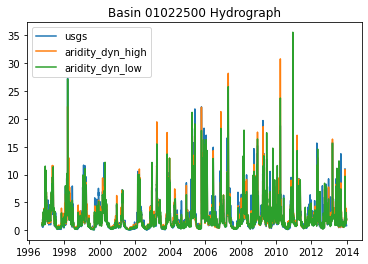

In [16]:
#Set plot title
plt.title(f'Basin {basins[0]} Hydrograph')
#Plot USGS observed streamflow data for an example basin
plt.plot(usgs[basins[0]].iloc[365:-365],label='usgs')
#Plot simulated streamflow values from one example experiment
plt.plot(mean_hydrographs[basins[0]][experiments[0]].iloc[365:-365],label=f'{experiments[0]}')
#Plot simulated streamflow values from another example experiment
plt.plot(mean_hydrographs[basins[0]][experiments[1]].iloc[365:-365],label=f'{experiments[1]}')
#Show legend
plt.legend()
#Display plot
plt.show()

In [17]:
#If interactive plots enabled, plot needs to be closed explicitly
plt.close()

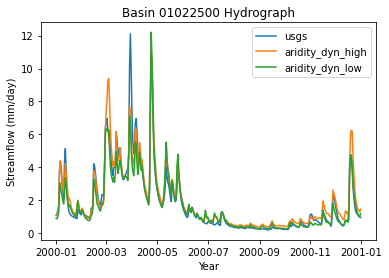

In [18]:
#A closer look
plt.title(f'Basin {basins[0]} Hydrograph')
plt.plot(usgs[basins[0]].loc['2000'],label='usgs')
plt.plot(mean_hydrographs[basins[0]][experiments[0]].loc['2000'],label=f'{experiments[0]}')
plt.plot(mean_hydrographs[basins[0]][experiments[1]].loc['2000'],label=f'{experiments[1]}')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Streamflow (mm/day)')
plt.show()

In [19]:
plt.close()

##### Calculate metrics from observed and simulated streamflow

Using the mean hydrographs calculated/loaded above, we will use our test date ranges to create masks as to only run metric calculations on the specified test years.

In [20]:
#If this file does not already exist or if we want to overwrite it...
if not f'basin_metrics_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl' in env_saves or overwrite == True:
    
    #Initialize metrics_dict
    metrics_dict = {}

    #For every experiment...
    for experiment in experiments:
        
        #Create dataframe with basin index and metric columns
        print(f'Calculating metrics for {experiment}...')
        metrics_dict[experiment] = pd.DataFrame(index=basins,columns=metrics_names)
        
        #For every metric and corresponding function pair...
        for name,func in zip(tqdm(metrics_names),metrics):
            
            #For every basin...
            for basin in basins:
                
                #Create a list of test dates stacked into one datetime index
                mask = pd.DatetimeIndex(np.unique(np.hstack(test_years_dict[experiment][basin])))
                
                #Get observed values for the dates in the mask
                obs = usgs[basin].loc[mask]
                #Get simualted values for the dates in the mask
                sim = mean_hydrographs[basin][experiment].loc[mask]
                
                #Calculate metrics between observed and simulated streamflow values
                metrics_dict[experiment][name].loc[basin] = func(obs,sim)
    
    #Save metrics_dict
    with open(env_saves_dir / f'basin_metrics_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'wb') as f:
        pkl.dump(metrics_dict, f)

#If the file already exists and we don't want to overwrite it...
else:

    #Load metrics dict
    with open(env_saves_dir / f'basin_metrics_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'rb') as f:
        metrics_dict = pkl.load(f)
    

##### Create NWM benchmark and calculate metrics

As mentioned in notebook 1/X, using the NWM run as a benchmark may provide insight into the comparative predictive ability and degredation of NH and SAC-SMA models. If we specified that we only wanted to run experiments on data from years also avaliable for the NWM, this is where that benchmark materializes.

Here we load in the supplemental CAMELS attributes file. This will be useful for several reasons; in this case, we need to extract basin information to convert NWM streamflow (m3/s) to mm to match model simulations.

In [21]:
#Load CAMELS attributes file with basin id as index
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

In [22]:
#If we are ensembling a random run (the NWM was not trained on extreme values, more closely related to random runs)...
if exp_type == 'random':
    
    #If the file does not already exist or if we want to overwrite it...
    if not f'nwm_random_{forcing}_{years}.pkl' in env_saves or overwrite == True:

        #Load the streamflow simulations from the nwm run
        with open(nwm_streamflow,'rb') as f:
            nwm = pkl.load(f)

        #Load the NWM identification key (basins labeled differently between CAMELS and NWM)
        with open(nwm_camels_ids,'rb') as f:
            camels_nwm_basins = np.load(f)

        #Create a dataframe
        keys_basins_dict = pd.DataFrame()
        #Load the nwm basin keys
        keys_basins_dict['nwm_keys'] = nwm.keys()
        #And the camels ids so that we can relate the two them
        keys_basins_dict['camels_id'] = camels_nwm_basins    

        #Create a new dictionary (fixed refers to relating the camels ids to the nwm keys)
        nwm_fixed = {}

        #And for every nwm key, camels id pair
        for key,basin in zip(keys_basins_dict['nwm_keys'],keys_basins_dict['camels_id']):
            
            #Load simulations for a basin into a basin's dataframe
            nwm_fixed[basin] = nwm[key]

        #Retrieve area index information from attributes for conversion
        area_index='area_geospa_fabric'

        #Define conversion values
        #Seconds in a day
        sid = 60*60*24
        #Meters in a kilometer
        mikm = 0.001
        #Millimeters in a meter
        mmim = 0.001

        #Create dictionary to contain converted streamflow values
        nwm_scaled = {}
        
        #For every basin...
        for i, basin in enumerate(basins):  
            
            #Create a dictionary entry for a basin
            nwm_scaled[basin] = []
            #Retreive area index attribute for a basin
            A = attributes.loc[int(basin), area_index]
            #Create conversion factor using conversion values defined above
            conversion_factor = sid * mmim / A
            #Multiply conversion factor by nwm simulation values and save into nwm_scaled
            nwm_scaled[basin] = conversion_factor * nwm_fixed[int(basin)]['NWM_RUN']

        #And for every basin...
        for basin in basins:
            
            #Clip the basin's dataframe based on the defined index
            nwm_scaled[basin] = nwm_scaled[basin].loc[index]

Now we want to calculate metrics for the NWM run.

In [23]:
#If we are ensembling a random run...
if exp_type == 'random':

    #And if the file does not already exist or we want to overwrite it...
    if not f'basin_metrics_nwm_random_{forcing}_{years}.pkl' in env_saves or overwrite == True:

        #Initialize metrics_dict
        nwm_metrics_dict = {}
        
        print(f'Calculating NWM metrics...')

        #For every experiment...
        for experiment in tqdm(experiments):
            
            #Create dataframe with basin index and metric columns
            nwm_metrics_dict[experiment] = pd.DataFrame(index=basins,columns=metrics_names)

            #For every metric to be calculated...
            for name,func in zip(metrics_names,metrics):

                #For every basin...
                for basin in basins:

                    mask = pd.DatetimeIndex(np.unique(np.hstack(test_years_dict[experiment][basin])))

                    #Get observed values for the dates in the mask
                    obs = usgs[basin].loc[mask]
                    sim = nwm_scaled[basin].loc[mask]
                    
                    #Calculate metrics between observed and simulated streamflow values
                    nwm_metrics_dict[experiment][name].loc[basin] = func(obs,sim)
                    
        #Save metrics_dict
        with open(env_saves_dir / f'basin_metrics_nwm_random_{forcing}_{years}.pkl', 'wb') as f:
            pkl.dump(nwm_metrics_dict, f)
    
    #If the file already exists and we do not want to overwrite it...
    else:

        #Load metrics dict
        with open(env_saves_dir / f'basin_metrics_nwm_random_{forcing}_{years}.pkl', 'rb') as f:
            nwm_metrics_dict = pkl.load(f)

In [24]:
#If we are ensembling a random run...
if exp_type == 'random':
    
    #If the file does not already exist or we want to overwrite it...
    if not f'cdfs_nwm_random_{forcing}_{years}.pkl' in env_saves or overwrite == True:

        #Initialize dictionary to store sorted metric values
        nwm_cdfs = {}

        #For every experiment...
        for experiment in experiments:
                        
            #Initialize experiment level
            nwm_cdfs[experiment] = {}

            #For every metric...
            for metric in list(nwm_metrics_dict[experiment].keys()):

                #Sort the metric values in increasing order
                x = np.sort(nwm_metrics_dict[experiment][metric].dropna(axis=0))
                #Create range based on length of x
                y = np.arange(len(x))/(float(len(x)))
                #Make y a list
                y = y.tolist()

                #Initialize metric levl
                nwm_cdfs[experiment][metric] = {}

                #Save x and y lists in cdfs dictionary
                nwm_cdfs[experiment][metric]['x'] = x
                nwm_cdfs[experiment][metric]['y'] = y

        #Save cdfs
        with open(env_saves_dir / f'cdfs_nwm_random_{forcing}_{years}.pkl', 'wb') as f:
            pkl.dump(nwm_cdfs, f)

    #If the file already exists and we do not want to overwrite it...
    else:

        #Load cdfs
        with open(env_saves_dir / f'cdfs_nwm_random_{forcing}_{years}.pkl', 'rb') as f:
            nwm_cdfs = pkl.load(f)

Now that we've created random benchmarks for the NWM run, let's plot them.

In [25]:
#If we are ensembling a random run...
if exp_type == 'random':

    #For every metric and associated axes ranges...
    for metric,ax in zip(plot_metrics,axes):
        
        #For every experiment...
        for experiment in experiments:

            #Define x and y from the nwm_cdfs dictionary
            x = nwm_cdfs[experiment][metric]['x']
            y = nwm_cdfs[experiment][metric]['y']

            #Make sure the experiment is int type
            experiment = int(experiment)

            #If the experiment is one less than the length of the amount of experiments...
            if experiment == len(experiments)-1:

                #Plot and label
                plt.plot(x, y,label = f'nwm_random',c='grey',alpha=0.5,lw=0.5)

            #If the experiment is any other value...
            else:

                #Just plot
                plt.plot(x, y,c='grey',alpha=0.5,lw=0.5)

    #Add grid
    plt.grid()
    #Define axis limits
    plt.axis(ax)
    #Show legend
    plt.legend()
    #Define x label
    plt.xlabel(f'{metric}')
    #Define y label
    plt.ylabel('Frequency (among 531 bains)')

    #Show plot
    plt.show()

In [26]:
#If interactive plots enabled, plot needs to be explicitly closed
plt.close()

### Metrics Cumulative Density Function Plots

Depending on the plot_all_metrics value, here we will create and plot cumulative density function (cdf) plots to visualize and compare model performance across simulations.

In [27]:
#If the file does not already exist or we want to overwrite it...
if not f'cdfs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl' in env_saves or overwrite == True:
    
    #Initialize dictionary to store sorted metric values
    cdfs = {}

    #For every experiment...
    for experiment in experiments:
        
        #Initialize experiment level
        cdfs[experiment] = {}
        
        #For every metric...
        for metric in list(metrics_dict[experiment].keys()):
            
            #Sort the metric values in increasing order
            x = np.sort(metrics_dict[experiment][metric].dropna(axis=0))
            #Create range based on length of x
            y = np.arange(len(x))/(float(len(x)))
            #Make y a list
            y = y.tolist()
            
            #Initialize metric levl
            cdfs[experiment][metric] = {}

            #Save x and y lists in cdfs dictionary
            cdfs[experiment][metric]['x'] = x
            cdfs[experiment][metric]['y'] = y
    
    #Save cdfs
    with open(env_saves_dir / f'cdfs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'wb') as f:
        pkl.dump(cdfs, f)

#If the file already exists and we do not want to overwrite it...
else:
    
    #Load cdfs
    with open(env_saves_dir / f'cdfs_{model}_{inputs}_{exp_type}_{forcing}_{years}.pkl', 'rb') as f:
        cdfs = pkl.load(f)

Note that the following cell was designed specifically for aridity and p_mean experiments only.

In [28]:
#If we ensembled extreme runs...
if exp_type == 'extreme':
    
    #Initialize colors dictionary to represent experiment type
    exp_colors = {}

    #Lighter colors represent experiments testing on low climate variables and vice versa
    exp_colors['aridity_dyn_high'] = ['r','-']
    exp_colors['aridity_dyn_low'] = ['lightcoral','-']
    exp_colors['p_mean_dyn_high'] = ['blue','-']
    exp_colors['p_mean_dyn_low'] = ['cornflowerblue','-']

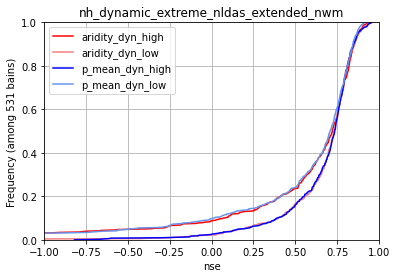

In [29]:
#For every metric and associated axes ranges...
for metric,ax in zip(plot_metrics,axes):
    
    #For every experiment...
    for experiment in experiments:
        
        #If we ensembled extreme runs...
        if exp_type == 'extreme':
            
            #Define line variables according to exp_colors dict
            c = exp_colors[experiment][0]
            l = exp_colors[experiment][1]
            
            #Define x,y values from cdfs_dict
            x = cdfs[experiment][metric]['x']
            y = cdfs[experiment][metric]['y']
            
            #Plot and label x and y values
            plt.plot(x, y, l,label = f'{experiment}',c=c)
            
        #If we ensembled random runs...
        if exp_type == 'random':
            
            #Define x,y values from cds_dict
            x = cdfs[str(experiment)][metric]['x']
            y = cdfs[str(experiment)][metric]['y']
            
            #Plot and label x and y values
            plt.plot(x, y, label = f'{experiment}')
    
    #Add grid
    plt.grid()
    #Define axis limits
    plt.axis(ax)
    #Show legend
    plt.legend()
    #Define x label
    plt.xlabel(f'{metric}')
    #Define y label
    plt.ylabel('Frequency (among 531 bains)')
    #Define plot title
    plt.title(f'{model}_{inputs}_{exp_type}_{forcing}_{years}')

    #Show plot
    plt.show()

In [30]:
#If interactive plots avaliable, explicitly close plot
plt.close()

### Metric Plots For Extreme Experiments

Metrics may be correlated with basin location, lat./lon., etc. so here we plot the metrics spatially to understand the geographic distribution and variance of the metrics.

##### Plot metrics spatially for one experiment 

/home/lmqualls/anaconda3/envs/neuralhydrology/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


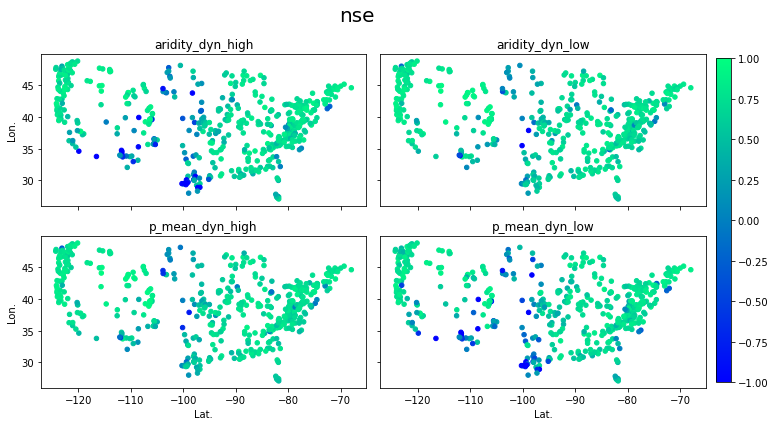

In [31]:
#Attributes reloaded just in case we want to rerun 
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

#If we are ensembling an extreme experiment...
if exp_type == 'extreme':

    #Drop attribute columns that are not quantitative values 
    #(could potentially be included if numerically categorized)
    drop_cols = ['high_prec_timing','low_prec_timing','geol_1st_class',
                 'geol_2nd_class','dom_land_cover','water_frac','organic_frac']

    #Drop drop_cols
    attributes = attributes.drop(drop_cols, axis=1)
    #Drop any columns that are not in the basins_int list (just in case)
    attributes = attributes.loc[basins_int]

    #Initiate lists of basin latitudes and longitudes
    plot_lats = []
    plot_lons = []

    #For every basin...
    for basin in basins:
        
        #Append lat/long from attribute columns to lists
        plot_lats.append(attributes.loc[int(basin),'gauge_lat'])
        plot_lons.append(attributes.loc[int(basin),'gauge_lon'])

    #Make list arrays
    plot_lats = np.array(plot_lats)
    plot_lons = np.array(plot_lons)

    #Variables for subplots; names do not represent anything
    n = [0,0,1,1]
    m = [0,1,0,1]

    #For every metric and associated axes...
    for metric,a in zip(plot_metrics,axes):

        #Create a 2x2 grid of plots (one plot for each experiment)
        fig, axs = plt.subplots(2,2,figsize = (10,6), sharex=True, sharey=True)

        #For every experiment...
        for i,experiment in enumerate(experiments):

            #Create throwaway list of metrics
            m_list = []

            #For every basin...
            for basin in basins:
                
                #Get metric data for a basin for that experiment
                m_data = metrics_dict[experiment].loc[basin,metric]
                #Append that data to m_list
                m_list.append(m_data)

            #Plot scatter plot of basin locations and color based on their metric value
            im = axs[n[i],m[i]].scatter(plot_lons, plot_lats,
                c=np.array(m_list),
                s=20,
                vmin=a[0],vmax=a[1],
                cmap='winter')

            #Return the values (min, max) that are mapped to the colormap limits
            clims = im.get_clim()
            #Set main plot title
            fig.suptitle(f'{metric}', fontsize=20)
            #Set plot titles based on location and corresponding experiment
            axs[n[i],m[i]].set_title(f'{experiment}')


            #Define x and y labels
            for ax in axs.flat:
                
                #Set x and y labels
                ax.set(xlabel='Lat.', ylabel='Lon.')

        #Hide x labels and tick labels for top plots and y ticks for right plots.
        for ax in axs.flat:
            
            #Only show x and y labels on outer plots
            ax.label_outer()    

        #Add colorbar
        fig.subplots_adjust(right=0.8)
        #Specify colorbar dimensions, size, and location
        cbar_ax = fig.add_axes([1, 0.11, 0.02, 0.75])
        #Show colorbar, specify the data we are coloring, and show it
        fig.colorbar(im, cax=cbar_ax)

        #Plot with tight layout
        plt.tight_layout()
        #Show plot
        plt.show()

In [32]:
#If interactive plots enabled, plot needs to be explicitly closed
plt.close()

##### Plot metrics difference of two extreme experiments spatially

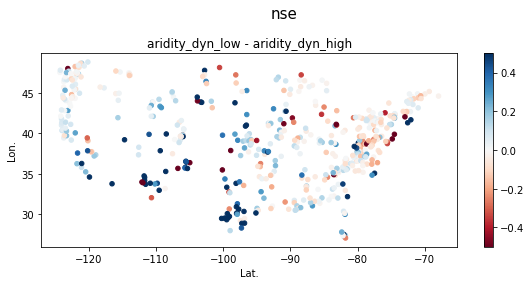

In [35]:
#If we are ensembling an extreme experiment...
if exp_type == 'extreme':

    #For every metric and associated axes...
    for metric,a in zip(plot_metrics,axes):
        
        #Initalize plot
        plt.figure(figsize=(8,4))

        #Create throwaway list of metrics
        m_list = []

        #For every basin...
        for basin in basins:
            #Get metric data for a basin for that experiment
            m_data = metrics_dict[experiments[1]].loc[basin,metric] - metrics_dict[experiments[0]].loc[basin,metric]
            #Append that data to m_list
            m_list.append(m_data)

        #Plot scatter plot of basin locations and color based on their metric value
        im = plt.scatter(plot_lons, plot_lats,
            c=np.array(m_list),
            s=20,
            vmin=-0.5,vmax=0.5,
            cmap='RdBu')

        #Return the values (min, max) that are mapped to the colormap limits
#         clims = im.get_clim()
        plt.title(f'{experiments[1]} - {experiments[0]}')
        plt.suptitle(f'{metric}', fontsize=15)
        plt.colorbar(im)
        plt.xlabel('Lat.')
        plt.ylabel('Lon.')

    #Plot
    plt.tight_layout()
#     plt.show()

In [34]:
#If interactive plots enabled, plot needs to be explicitly closed
plt.close()

Now that we have ensembled a model's runs, calculated its metrics, and took a look at differences performance under different climate distribution changes, we can use the output files from this notebook to compare two different sets of experiments.